In [1]:
import sys, os

import pandas as pd
import numpy as np

from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support


import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sn

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
try:
    data = pd.read_csv('../dataset/new_clean_bo3.csv', encoding='utf-8-sig', converters={'regions':eval}, index_col=0)
except:
    sys.path.append(os.path.realpath('../'))
    data = pd.read_csv('../dataset/new_clean_bo3.csv', encoding='utf-8-sig', converters={'regions':eval}, index_col=0)

data = data.drop(columns=['pre_routes', 'freq'])
data.reset_index(level=0, inplace=True)
data.head(10)

,level_0,index,vehicle_id,p_start,p_temp,p_end,label,regions
0,0,0,100000025,"(106.74, 10.8014)","(106.73899999999999, 10.8012)","(106.738, 10.8012)",False,"(phường_thảo_điền_quận_2, phường_thảo_điền_quậ..."
1,1,16,100000025,"(106.74, 10.8014)","(106.73899999999999, 10.8012)","(106.73100000000001, 10.7996)",False,"(phường_thảo_điền_quận_2, phường_thảo_điền_quậ..."
2,2,21,100000025,"(106.74, 10.8014)","(106.73899999999999, 10.8012)","(106.721, 10.7981)",False,"(phường_thảo_điền_quận_2, phường_thảo_điền_quậ..."
3,3,40,100000025,"(106.74, 10.8014)","(106.73899999999999, 10.8012)","(106.695, 10.7912)",False,"(phường_thảo_điền_quận_2, phường_thảo_điền_quậ..."
4,4,50,100000025,"(106.74, 10.8014)","(106.73899999999999, 10.8012)","(106.68799999999999, 10.7858)",False,"(phường_thảo_điền_quận_2, phường_thảo_điền_quậ..."
5,5,59,100000025,"(106.74, 10.8014)","(106.73899999999999, 10.8012)","(106.681, 10.7926)",False,"(phường_thảo_điền_quận_2, phường_thảo_điền_quậ..."
6,6,102,100000025,"(106.74, 10.8014)","(106.738, 10.8012)","(106.736, 10.8026)",False,"(phường_thảo_điền_quận_2, phường_thảo_điền_quậ..."
7,7,106,100000025,"(106.74, 10.8014)","(106.738, 10.8012)","(106.734, 10.8034)",False,"(phường_thảo_điền_quận_2, phường_thảo_điền_quậ..."
8,8,107,100000025,"(106.74, 10.8014)","(106.738, 10.8012)","(106.73200000000001, 10.8028)",False,"(phường_thảo_điền_quận_2, phường_thảo_điền_quậ..."
9,9,112,100000025,"(106.74, 10.8014)","(106.738, 10.8012)","(106.73200000000001, 10.8)",False,"(phường_thảo_điền_quận_2, phường_thảo_điền_quậ..."


In [3]:
data['regions'] = data['regions'].apply(lambda x: list(x))
data['label'] = data['label'].apply(lambda label: -1 if label == False else 1)
# data = data.sample(frac=0.4)

print("N_normal: ",len(data[data['label']==-1]))
print("N_abnormal: ",len(data[data['label']==1]))
data['label'].describe()

N_normal:  9401
N_abnormal:  5460


count    14861.000000
mean        -0.265191
std          0.964228
min         -1.000000
25%         -1.000000
50%         -1.000000
75%          1.000000
max          1.000000
Name: label, dtype: float64

# Active Learning

In [4]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling, entropy_sampling, margin_sampling

X = np.array(data['regions'].tolist())
y = np.array(data['label'].tolist())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

vectorizer = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)
vectorizer.fit(X_train)

X_train.shape, X_test.shape, len(vectorizer.get_feature_names())

d:\pythonapp\v2\.envgps-v2\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


((11145, 3), (3716, 3), 164)

In [5]:
initial_idx = np.random.choice(range(len(X_train)), size=int(X_train.shape[0]*0.6), replace=False)

X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]
X_pool, y_pool = np.delete(X_train, initial_idx, axis=0), np.delete(y_train, initial_idx, axis=0)



precision_test = []
recall_test = []
f1_test = []
acc_test = []

X_initial_mat = vectorizer.transform(X_initial)
X_pool_mat = vectorizer.transform(X_pool)
X_test_mat = vectorizer.transform(X_test)


n_initial = 100
n_queries = 50
clf = SVC(C=5.0, kernel='rbf', tol=1e-5, max_iter=-1, random_state=42, probability=True)


learner = ActiveLearner(
    estimator=clf,
    query_strategy=margin_sampling,
    X_training=X_initial_mat, y_training=y_initial
)

y_pred = learner.predict(X_test_mat)

precision,recall,fscore,support = precision_recall_fscore_support(y_test,y_pred,average='macro')
precision_test.append(precision)
recall_test.append(recall)
f1_test.append(fscore)
acc_test.append(accuracy_score(y_test,y_pred))

print(X_initial.shape, X_pool.shape, X_test.shape)
print("F1-test: ", fscore)

(6687, 3) (4458, 3) (3716, 3)
F1-test:  0.8116414632085832


In [6]:
for i in range(n_queries):
#     print(X_pool_mat.shape)
    try:
        query_idx, query_instance = learner.query(X_pool_mat, n_instances=int(X_pool_mat.shape[0]/n_queries)+1)
    except:
        break

    y_new = y_pool[query_idx]
    learner.teach(X_pool_mat[query_idx], y_new)
    
    X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx, axis=0)
    X_pool_mat = vectorizer.transform(X_pool)
    
    y_pred = learner.predict(X_test_mat)

    precision,recall,fscore,support = precision_recall_fscore_support(y_test,y_pred,average='macro')
    precision_test.append(precision)
    recall_test.append(recall)
    f1_test.append(fscore)
    acc_test.append(accuracy_score(y_test,y_pred))
    
    print('F1-score after query {n}: {acc:0.4f}'.format(n=i + 1, acc=f1_test[i]))


    
mean_precision_test = np.mean(precision_test)
mean_recall_test = np.mean(recall_test)
mean_f1_test = np.mean(f1_test)
mean_acc_test = np.mean(acc_test)

test_perfm = [mean_precision_test, mean_recall_test, mean_f1_test, mean_acc_test]

performance = pd.DataFrame([test_perfm], columns = ['precision', 'recall', 'f1-score', 'accuracy'], index=['test'])
performance

F1-score after query 1: 0.8116
F1-score after query 2: 0.8145
F1-score after query 3: 0.8153
F1-score after query 4: 0.8194
F1-score after query 5: 0.8203
F1-score after query 6: 0.8225
F1-score after query 7: 0.8227
F1-score after query 8: 0.8224
F1-score after query 9: 0.8243
F1-score after query 10: 0.8251
F1-score after query 11: 0.8249
F1-score after query 12: 0.8266
F1-score after query 13: 0.8266
F1-score after query 14: 0.8259
F1-score after query 15: 0.8262
F1-score after query 16: 0.8262
F1-score after query 17: 0.8262
F1-score after query 18: 0.8265
F1-score after query 19: 0.8260
F1-score after query 20: 0.8260
F1-score after query 21: 0.8254
F1-score after query 22: 0.8254
F1-score after query 23: 0.8257
F1-score after query 24: 0.8257
F1-score after query 25: 0.8256
F1-score after query 26: 0.8261
F1-score after query 27: 0.8270
F1-score after query 28: 0.8270
F1-score after query 29: 0.8270
F1-score after query 30: 0.8271
F1-score after query 31: 0.8271
F1-score after qu

,precision,recall,f1-score,accuracy
test,0.837635,0.817419,0.82558,0.844372


In [7]:
test_perfm = [precision_test[-1], recall_test[-1], f1_test[-1], acc_test[-1]]
test_perfm_al = pd.DataFrame([test_perfm], columns = ['precision', 'recall', 'f1-score', 'accuracy'], index=['test_al'])
test_perfm_al

,precision,recall,f1-score,accuracy
test_al,0.838955,0.820783,0.828284,0.84634


# Machine Learning

In [8]:
X_train_mat = vectorizer.transform(X_train)
X_test_mat = vectorizer.transform(X_test)

clf = SVC(C=5.0, kernel='rbf', tol=1e-5, max_iter=-1, random_state=42, probability=True)
clf.fit(X_train_mat, y_train)

y_pred_ml = clf.predict(X_test_mat)
ml_precision, ml_recall, ml_fscore, ml_support = precision_recall_fscore_support(y_test,y_pred_ml,average='macro')

ml_acc = accuracy_score(y_test,y_pred_ml)
test_perfm_ml = pd.DataFrame([[ml_precision,ml_recall,ml_fscore, ml_acc]], columns = ['precision', 'recall', 'f1-score', 'accuracy'], index=['test_ml'])
test_perfm_ml

,precision,recall,f1-score,accuracy
test_ml,0.840685,0.822709,0.830154,0.847955


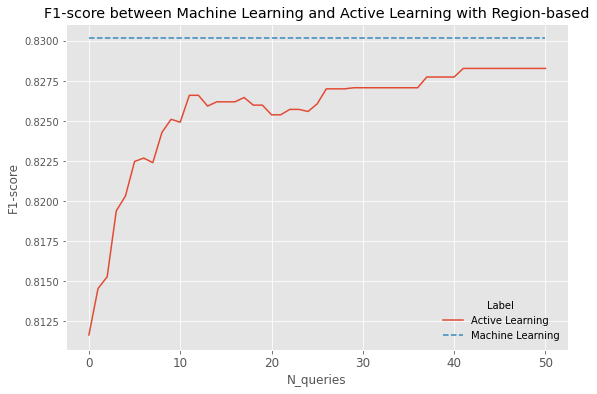

In [9]:
plt.rcParams['figure.figsize'] = (9.0, 6.0)
plt.rcParams['xtick.labelsize'] = 12
plt.plot(range(len(f1_test)),f1_test, label='Active Learning')
plt.plot(range(len(f1_test)),[ml_fscore]*(n_queries+1), '--',label='Machine Learning')
plt.xlabel('N_queries')
plt.ylabel('F1-score')
plt.legend(loc="lower right", title="Label", frameon=False)
plt.title("F1-score between Machine Learning and Active Learning with Region-based")
plt.show()